# Libraries

In [1]:
import geopandas as gpd
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances

from tslearn.clustering import TimeSeriesKMeans
from tslearn.metrics import dtw

# Load Data

In [2]:
DRIVE_PATH = "./data"
TIME_SERIES_PREPROCESSED_PATH = DRIVE_PATH + "/preprocessed/time_series_scaled"
FLATTEN_PREPROCESSED_PATH = DRIVE_PATH + "/preprocessed/flatten_scaled"

topics = [t.split(".")[0] for t in os.listdir(TIME_SERIES_PREPROCESSED_PATH)]
topics

['economic', 'health', 'social']

In [3]:
COUNTRY_CODE = "Country Code"
YEAR = "Year"

ts_datasets = {
    topic: pd.read_csv(f"{TIME_SERIES_PREPROCESSED_PATH}/{topic}.csv").set_index([COUNTRY_CODE, YEAR]).sort_index()
    for topic in topics
}

flatten_datasets = {
    topic: pd.read_csv(f"{FLATTEN_PREPROCESSED_PATH}/{topic}.csv").set_index(COUNTRY_CODE)
    for topic in topics
}

## Explain clusters functions

Validate clusters by checking how the value of the most important feature in the first component changes

In [4]:
def plot_time_series(
        dataset: pd.DataFrame, 
        time_series: list[tuple[str, str]], # country, color
        feature: str, 
        start_year=1992,
    ):
    """Plots flows of time series (specific feature) for listed countries"""
    for country, color in time_series:
        try:
            y = dataset.loc[country][feature]
            x = list(range(start_year, start_year + len(y)))
            plt.plot(x, y, color=color)
        except:
            print(f"Country {country} not found")
    plt.show()

In [5]:
def group_clusters(countries_clustered: dict[str, int]):
    """Returns list of lists of countries grouped by their label"""
    labels = set(countries_clustered.values())
    return [
        [country for country, c_label in countries_clustered.items() if c_label == label]
        for label in labels
    ]

In [6]:
def yield_countries(dataset: pd.DataFrame):
    """Yields each country once, in the order they are in the dataset"""
    last_country = None
    for country, _ in dataset.index:
        if country != last_country:
            yield country
            last_country = country

In [7]:
def most_common_features(countries: list[str], metric, dataset: pd.DataFrame):
    """
    Returns list of features orederd by mean distance between countries provided 
    devided by mean distance to rest of countries in the dataset 
    """
    features = dataset.columns
    featurses_mean_distance = []
    countries_dfs = [dataset.loc[country] for country in countries]
    other_countries_dfs = [dataset.loc[country] for country in set(yield_countries(dataset)).difference(countries)]

    for feature in features:
        cluster_time_series = [country_df[feature] for country_df in countries_dfs]
        cluster_distances = pairwise_distances(cluster_time_series, metric=metric)
        cluster_mean = np.mean(cluster_distances)

        no_cluster_time_series = [country_df[feature] for country_df in other_countries_dfs]
        no_cluster_distances = pairwise_distances(cluster_time_series, no_cluster_time_series, metric=metric)
        no_cluster_mean = np.mean(no_cluster_distances)

        featurses_mean_distance.append((feature, cluster_mean / no_cluster_mean))

    return sorted(featurses_mean_distance, key=lambda pair: pair[1])

# Visualization of clusters of countries on a world map

In [8]:
def visualzie_countries_clusters(countries_labels: dict[str, int]):
    """countries_labels is dict of {COUNTRY CODE: Label if a cliuster}."""
    countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
    countries["Label"] = [countries_labels[c] if c in countries_labels else None for c in countries["iso_a3"]]
    countries.plot(
        column="Label", 
        #cmap="Accent_r", 
        figsize=(15, 6), 
        legend=True, 
        missing_kwds ={
            "color": "lightgrey",
            "hatch": "///",
            "label": "Missing values",
        }
    )

# Part 1. PoC: Cluster countries with simple data (PCA, KMeans)

## PCA

In [9]:
# fit PCA for each dataset
pcas = {
    topic: PCA().fit(dataset.values)
    for topic, dataset in flatten_datasets.items()
}

# using PCAs, reduce the dimensionality of the data
pca_datasets = {
    topic: pd.DataFrame(pca.transform(dataset.values), index=dataset.index)
    for (topic, pca), dataset in zip(pcas.items(), flatten_datasets.values())
}

## Percentage of variance retained for the first components

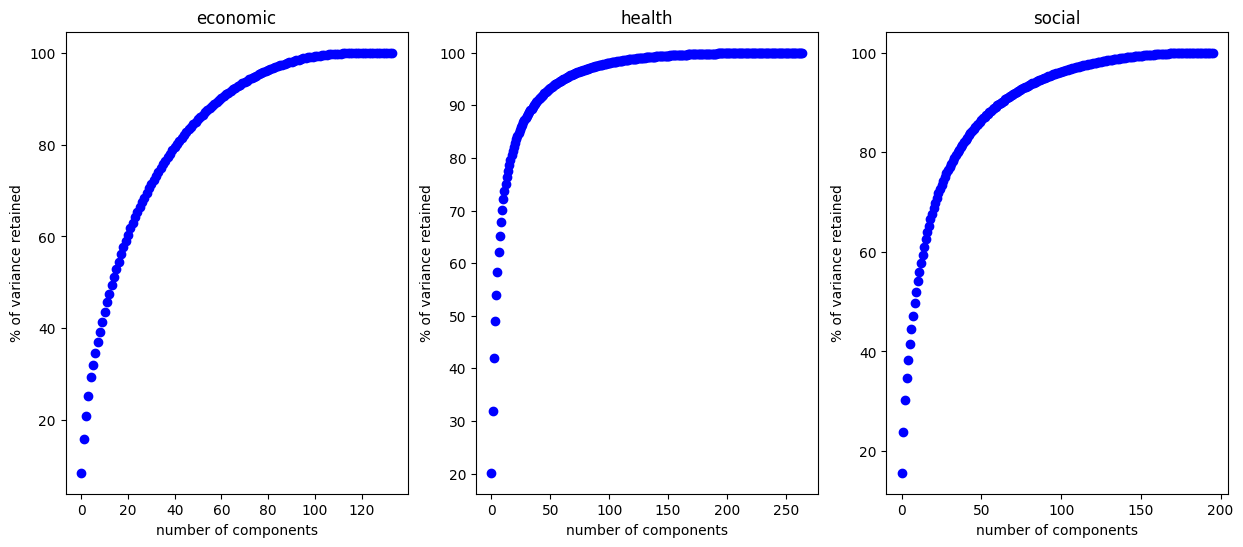

In [10]:
_, axs = plt.subplots(1, len(pcas), figsize=(15, 6))
reatined_variance = {topic: np.cumsum(pca.explained_variance_ratio_) for topic, pca in pcas.items()}

for (topic, variance), ax in zip(reatined_variance.items(), axs):
    ax.plot(variance * 100, "bo")
    ax.set_title(topic)
    ax.set_xlabel("number of components")
    ax.set_ylabel(f"% of variance retained")
plt.show()    

## Features and years behind components

In [11]:
def order_by_component(features, component):
    """Sorts features by how much they increase the value of a given component"""
    return sorted(list(zip(component, features)), key=lambda pair: pair[0], reverse=True)


def top_bottom_components_features(features, components, count=15):
    """
    For each component, he finds {count} features that most increase and decrease its value. 
    The result is wrapped in a DataFrame.
    """
    ordered = [[(round(c, 3), f) for c, f in order_by_component(features, component)] for component in components]
    return pd.DataFrame({
        f"{i + 1} component": [f"top {count}"] + ordered[i][:count] + [f"bottom {count}"] + ordered[i][-count:] 
        for i in range(len(components))
    })


pca_n_components = 5

### Economic data

In [12]:
economic_components_features = top_bottom_components_features(
    flatten_datasets["economic"].columns, pcas["economic"].components_[:pca_n_components]
)

economic_components_features

,1 component,2 component,3 component,4 component,5 component
0,top 15,top 15,top 15,top 15,top 15
1,"(0.136, 1992 [YR1992] Merchandise imports from...","(0.126, 2009 [YR2009] GDP growth (annual %))","(0.106, 1998 [YR1998] GDP per capita growth (a...","(0.191, 1992 [YR1992] GDP growth (annual %))","(0.149, 2006 [YR2006] Foreign direct investmen..."
2,"(0.135, 1992 [YR1992] Merchandise imports from...","(0.124, 2020 [YR2020] GDP growth (annual %))","(0.101, 2008 [YR2008] Merchandise exports by t...","(0.179, 1992 [YR1992] GDP per capita growth (a...","(0.141, 1995 [YR1995] Merchandise imports from..."
3,"(0.134, 1992 [YR1992] Merchandise imports by t...","(0.123, 2009 [YR2009] GDP per capita growth (a...","(0.096, 2008 [YR2008] Merchandise exports (cur...","(0.159, 1993 [YR1993] GDP growth (annual %))","(0.139, 2017 [YR2017] Merchandise imports from..."
4,"(0.11, 1997 [YR1997] Merchandise imports by th...","(0.118, 2020 [YR2020] GDP per capita growth (a...","(0.096, 1998 [YR1998] GDP growth (annual %))","(0.154, 1993 [YR1993] GDP per capita growth (a...","(0.137, 1996 [YR1996] Merchandise imports from..."
5,"(0.104, 1998 [YR1998] Merchandise imports by t...","(0.103, 2020 [YR2020] Merchandise imports from...","(0.083, 1997 [YR1997] GDP per capita growth (a...","(0.136, 2020 [YR2020] Merchandise imports from...","(0.126, 2008 [YR2008] Foreign direct investmen..."
6,"(0.1, 1993 [YR1993] Merchandise exports to low...","(0.09, 1992 [YR1992] Merchandise imports from ...","(0.082, 2008 [YR2008] Foreign direct investmen...","(0.136, 1994 [YR1994] GDP growth (annual %))","(0.122, 2018 [YR2018] Merchandise imports from..."
7,"(0.091, 1993 [YR1993] Merchandise imports from...","(0.088, 1992 [YR1992] Merchandise exports to l...","(0.082, 2003 [YR2003] Foreign direct investmen...","(0.131, 1994 [YR1994] GDP per capita growth (a...","(0.122, 2007 [YR2007] Foreign direct investmen..."
8,"(0.09, 1993 [YR1993] Merchandise imports by th...","(0.086, 1992 [YR1992] Merchandise exports to l...","(0.076, 2008 [YR2008] GDP per capita, PPP (con...","(0.128, 2021 [YR2021] Merchandise imports from...","(0.118, 2008 [YR2008] Foreign direct investmen..."
9,"(0.088, 2007 [YR2007] Foreign direct investmen...","(0.085, 1993 [YR1993] Merchandise exports to l...","(0.076, 2021 [YR2021] Inflation, GDP deflator ...","(0.119, 2019 [YR2019] Merchandise imports from...","(0.117, 1992 [YR1992] Inflation, GDP deflator ..."


### Health data

In [13]:
health_components_features = top_bottom_components_features(
    flatten_datasets["health"].columns, pcas["health"].components_[:pca_n_components]
)

health_components_features

,1 component,2 component,3 component,4 component,5 component
0,top 15,top 15,top 15,top 15,top 15
1,"(0.075, 2021 [YR2021] Population ages 15-64, f...","(0.072, 2021 [YR2021] Population, male (% of t...","(0.075, 1992 [YR1992] Population ages 0-14, male)","(0.073, 2021 [YR2021] Population ages 30-34, m...","(0.083, 2021 [YR2021] Population ages 0-14, to..."
2,"(0.072, 2021 [YR2021] Population ages 15-64 (%...","(0.066, 1992 [YR1992] Population ages 15-64, m...","(0.074, 1992 [YR1992] Population ages 0-14, to...","(0.069, 2018 [YR2018] Population ages 25-29, m...","(0.083, 2021 [YR2021] Population ages 0-14, fe..."
3,"(0.068, 2021 [YR2021] Population ages 0-14, fe...","(0.064, 2020 [YR2020] Population, male (% of t...","(0.074, 1992 [YR1992] Population ages 0-14, fe...","(0.068, 2019 [YR2019] Population ages 25-29, m...","(0.082, 2020 [YR2020] Population ages 0-14, to..."
4,"(0.067, 2021 [YR2021] Population ages 0-14, to...","(0.064, 1992 [YR1992] Population ages 15-64 (%...","(0.067, 1993 [YR1993] Population ages 0-14, male)","(0.068, 2021 [YR2021] Population ages 30-34, f...","(0.082, 2020 [YR2020] Population ages 0-14, fe..."
5,"(0.067, 2021 [YR2021] Population ages 15-64, m...","(0.062, 1993 [YR1993] Population ages 15-64, m...","(0.066, 1993 [YR1993] Population ages 0-14, to...","(0.066, 2017 [YR2017] Population ages 25-29, m...","(0.082, 2021 [YR2021] Population ages 0-14, male)"
6,"(0.067, 2021 [YR2021] Population ages 35-39, f...","(0.06, 1992 [YR1992] Population ages 15-64, fe...","(0.066, 1993 [YR1993] Population ages 0-14, fe...","(0.066, 2020 [YR2020] Population ages 30-34, m...","(0.082, 2020 [YR2020] Population ages 0-14, male)"
7,"(0.067, 2021 [YR2021] Population ages 0-14, male)","(0.06, 1992 [YR1992] Population ages 35-39, fe...","(0.058, 1994 [YR1994] Population ages 0-14, male)","(0.064, 2018 [YR2018] Population ages 25-29, f...","(0.079, 2019 [YR2019] Population ages 0-14, to..."
8,"(0.066, 2021 [YR2021] Population ages 40-44, f...","(0.06, 1992 [YR1992] Population ages 40-44, fe...","(0.057, 1994 [YR1994] Population ages 0-14, to...","(0.064, 2019 [YR2019] Population ages 25-29, f...","(0.078, 2019 [YR2019] Population ages 0-14, fe..."
9,"(0.065, 1992 [YR1992] Age dependency ratio, ol...","(0.059, 1993 [YR1993] Population ages 15-64 (%...","(0.057, 1994 [YR1994] Population ages 0-14, fe...","(0.062, 2020 [YR2020] Population ages 25-29, m...","(0.078, 2019 [YR2019] Population ages 0-14, male)"


### Social data

In [14]:
social_components_features = top_bottom_components_features(
    flatten_datasets["social"].columns, pcas["social"].components_[:pca_n_components]
)

social_components_features

,1 component,2 component,3 component,4 component,5 component
0,top 15,top 15,top 15,top 15,top 15
1,"(0.084, 1992 [YR1992] Agricultural land (sq. km))","(0.105, 1992 [YR1992] Employment to population...","(0.073, 2020 [YR2020] Unemployment, male (% of...","(0.101, 1992 [YR1992] Unemployment, youth tota...","(0.087, 1999 [YR1999] Unemployment, total (% o..."
2,"(0.084, 1993 [YR1993] Agricultural land (sq. km))","(0.103, 1992 [YR1992] Labor force participatio...","(0.071, 2020 [YR2020] Unemployment, total (% o...","(0.1, 1992 [YR1992] Unemployment, youth female...","(0.085, 2000 [YR2000] Unemployment, total (% o..."
3,"(0.084, 1993 [YR1993] Agricultural land (% of ...","(0.098, 1992 [YR1992] Employment to population...","(0.07, 2020 [YR2020] Unemployment, youth male ...","(0.099, 1993 [YR1993] Unemployment, youth tota...","(0.085, 1992 [YR1992] Population growth (annua..."
4,"(0.083, 1992 [YR1992] Agricultural land (% of ...","(0.093, 1993 [YR1993] Employment to population...","(0.068, 2020 [YR2020] Unemployment, youth tota...","(0.098, 1993 [YR1993] Unemployment, youth fema...","(0.078, 1999 [YR1999] Unemployment, male (% of..."
5,"(0.083, 2020 [YR2020] Employment to population...","(0.092, 1993 [YR1993] Labor force participatio...","(0.066, 2020 [YR2020] Unemployment, youth fema...","(0.096, 1993 [YR1993] Unemployment, male (% of...","(0.077, 1999 [YR1999] Unemployment, female (% ..."
6,"(0.08, 2020 [YR2020] Employment to population ...","(0.091, 1992 [YR1992] Labor force participatio...","(0.062, 2020 [YR2020] Unemployment, female (% ...","(0.095, 1993 [YR1993] Unemployment, youth male...","(0.077, 2000 [YR2000] Unemployment, male (% of..."
7,"(0.075, 1994 [YR1994] Agricultural land (sq. km))","(0.089, 1993 [YR1993] Employment to population...","(0.059, 2013 [YR2013] Unemployment, youth male...","(0.095, 1992 [YR1992] Unemployment, youth male...","(0.077, 2000 [YR2000] Unemployment, female (% ..."
8,"(0.075, 2021 [YR2021] Employment to population...","(0.086, 1994 [YR1994] Labor force participatio...","(0.057, 2016 [YR2016] Unemployment, youth male...","(0.094, 1992 [YR1992] Unemployment, total (% o...","(0.076, 2001 [YR2001] Unemployment, total (% o..."
9,"(0.074, 1994 [YR1994] Agricultural land (% of ...","(0.085, 1994 [YR1994] Employment to population...","(0.056, 2018 [YR2018] Unemployment, youth male...","(0.094, 1993 [YR1993] Unemployment, total (% o...","(0.076, 2000 [YR2000] Unemployment, youth tota..."


## Cluster countries with first PCA components and KMeans

In [15]:
kmeans_pca = {
    topic: KMeans(n_clusters=10, n_init="auto") for topic in flatten_datasets
}


countries_clustered_kmeans_pca = {}
for topic, dataset in flatten_datasets.items():
    labels = kmeans_pca[topic].fit_predict(pca_datasets[topic].values[:, :pca_n_components])
    countries_clustered = {country: label for country, label in zip(dataset.index, labels)}
    countries_clustered_kmeans_pca[topic] = countries_clustered

### Economic data

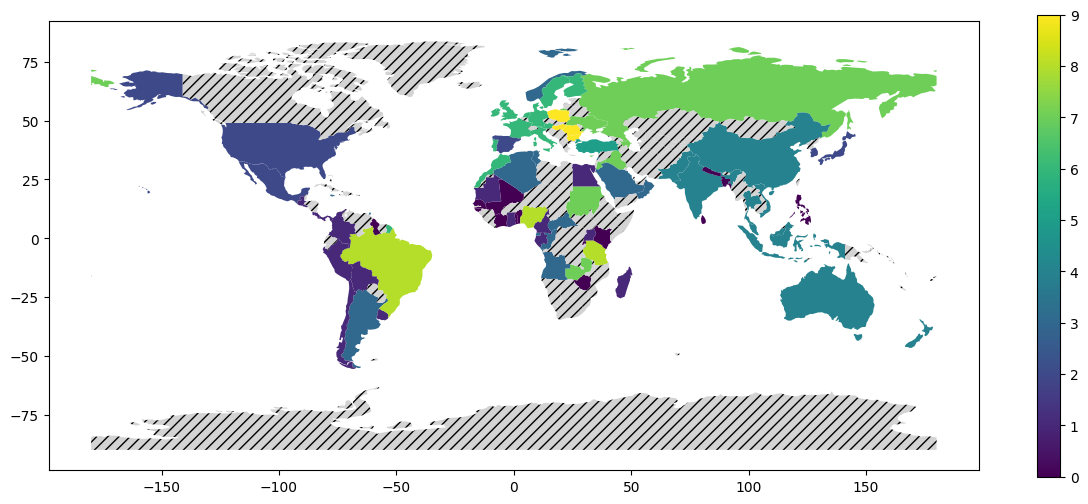

In [16]:
visualzie_countries_clusters(countries_clustered_kmeans_pca["economic"])

In [17]:
_economic_clusters = group_clusters(countries_clustered_kmeans_pca["economic"])
_most_common_economic_features = {}
for label, cluster in enumerate(_economic_clusters):
    feature = most_common_features(cluster, dtw, ts_datasets["economic"])[0][0]
    _most_common_economic_features[label] = feature

['BGR', 'CEB', 'HUN', 'POL', 'ROU']
GDP per capita, PPP (constant 2017 international $)


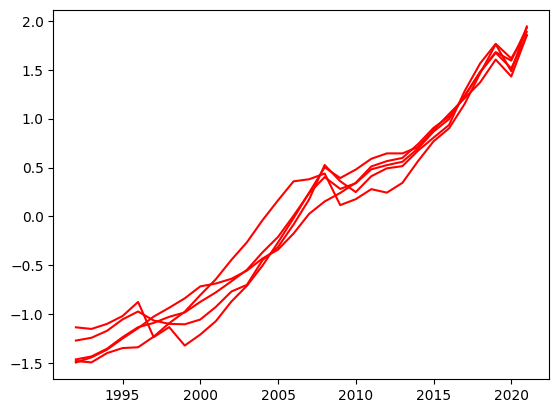

In [18]:
label = 9
cluster = _economic_clusters[label]
feature = _most_common_economic_features[label]

print(cluster)
print(feature)

plot_time_series(
    ts_datasets["economic"], 
    [(country, "red") for country in cluster],
    feature
)

### Health data

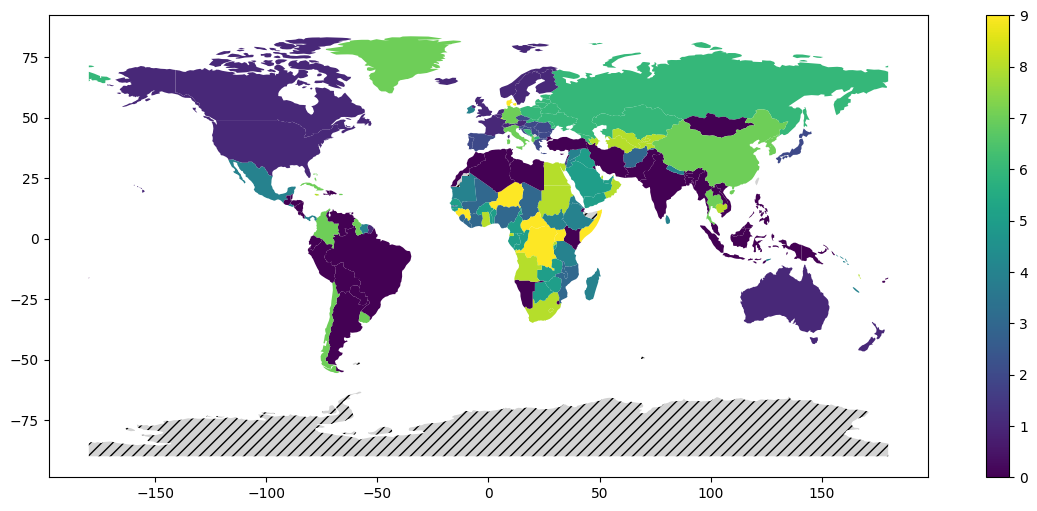

In [19]:
visualzie_countries_clusters(countries_clustered_kmeans_pca["health"])

In [20]:
_health_clusters = group_clusters(countries_clustered_kmeans_pca["health"])
_most_common_health_features = {}
for label, cluster in enumerate(_health_clusters):
    feature = most_common_features(cluster, dtw, ts_datasets["health"])[0][0]
    _most_common_health_features[label] = feature

['ARB', 'ARG', 'BGD', 'BHR', 'BLZ', 'BOL', 'BRA', 'BRN', 'BTN', 'CRI', 'CSS', 'CYP', 'DJI', 'DOM', 'DZA', 'EAR', 'ECU', 'FJI', 'FSM', 'GTM', 'HND', 'HTI', 'IBD', 'IBT', 'IDA', 'IDB', 'IDN', 'IDX', 'IND', 'IRN', 'KEN', 'KWT', 'LAC', 'LAO', 'LBN', 'LBY', 'LCA', 'LCN', 'LDC', 'LMC', 'LMY', 'MAR', 'MEA', 'MHL', 'MIC', 'MMR', 'MNA', 'MNG', 'MYS', 'NAM', 'NIC', 'PAK', 'PER', 'PHL', 'PNG', 'PRY', 'PSE', 'PSS', 'SAS', 'SWZ', 'SYC', 'TLA', 'TMN', 'TSA', 'TTO', 'TUN', 'TUR', 'VEN', 'VNM', 'WLD']
Population ages 15-64, female


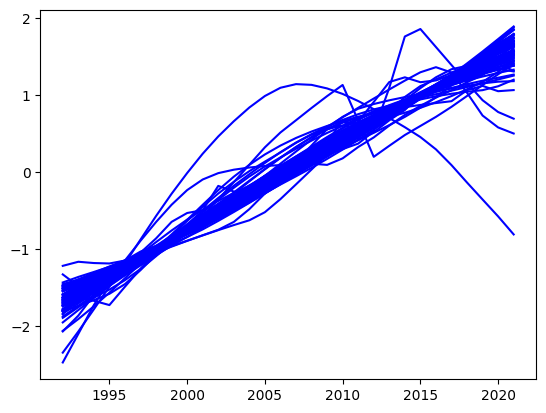

In [21]:
label = 0
cluster = _health_clusters[label]
feature = _most_common_health_features[label]

print(cluster)
print(feature)

plot_time_series(
    ts_datasets["health"], 
    [(country, "blue") for country in cluster],
    feature
)

### Social data

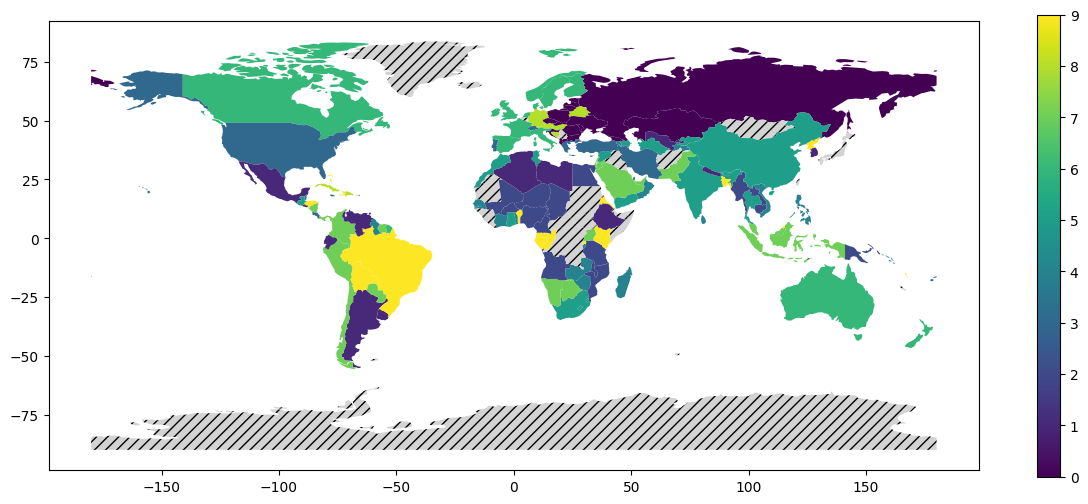

In [22]:
visualzie_countries_clusters(countries_clustered_kmeans_pca["social"])

In [23]:
_social_clusters = group_clusters(countries_clustered_kmeans_pca["social"])
_most_common_social_features = {}
for label, cluster in enumerate(_social_clusters):
    feature = most_common_features(cluster, dtw, ts_datasets["social"])[0][0]
    _most_common_social_features[label] = feature

['AZE', 'BTN', 'CHN', 'EAP', 'EAS', 'GHA', 'GTM', 'IBD', 'IND', 'KGZ', 'LSO', 'LTE', 'MAR', 'MNA', 'SAS', 'SWZ', 'SYR', 'TEA', 'THA', 'TKM', 'TMN', 'TON', 'TSA', 'TUN', 'UMC', 'YEM', 'ZAF']
Population, total


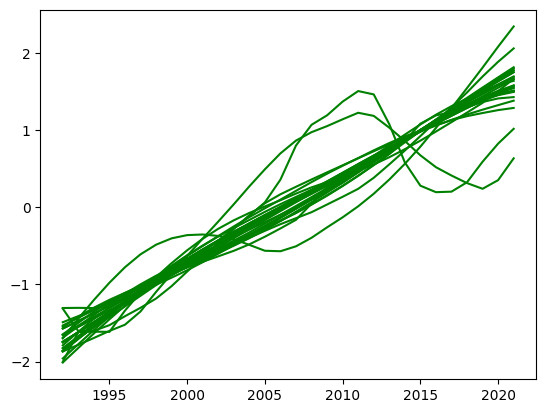

In [24]:
label = 5
cluster = _social_clusters[label]
feature = _most_common_social_features[label]

print(cluster)
print(feature)

plot_time_series(
    ts_datasets["social"], 
    [(country, "green") for country in cluster],
    feature
)

# Part 2. Fetaure extraction on time series data (TSNE, LSTM Autoencoder)

## TSNE

In [25]:
# define TSNEs to reduction to 1 dimension
tsnes_1_dim = {topic: TSNE(n_components=1) for topic in ts_datasets}

# using TSNEs, reduce the dimensionality of the data
tsne_1_dim_datasets = {
    topic: pd.DataFrame(tsne.fit_transform(dataset.values), index=dataset.index) 
    for (topic, dataset), tsne in zip(ts_datasets.items(), tsnes_1_dim.values())
}

In [26]:
# define TSNEs to reduction to 3 dimensions
tsnes_3_dim = {topic: TSNE(n_components=3) for topic in ts_datasets}

# using TSNEs, reduce the dimensionality of the data
tsne_3_dim_datasets = {
    topic: pd.DataFrame(tsne.fit_transform(dataset.values), index=dataset.index) 
    for (topic, dataset), tsne in zip(ts_datasets.items(), tsnes_3_dim.values())
}

## LSTM Autoencoder

In [27]:
def reshape_extract_countries_ts(all_countries_stacked: pd.DataFrame):
    """Returns a numpy array such that the first dimension is for countries and the second is for years"""
    n_years = len({y for _, y in all_countries_stacked.index})
    n_countries = len({c for c, _ in all_countries_stacked.index})
    n_features = len(all_countries_stacked.columns)
    return all_countries_stacked.values.reshape((n_countries, n_years, n_features)) \
        if n_features > 1 else all_countries_stacked.values.reshape((n_countries, n_years))

In [28]:
class LSTMAutoEncoder:

    def __init__(
            self, 
            encoder_layer_sizes: list[int], 
            decoder_layer_sizes: list[int], 
            window_length: int, n_features: int, 
            epochs: int = 100, 
            batch_size: int = 4
        ) -> None:
        self._epochs = epochs
        self._batch_size = batch_size

        make_lstm = lambda size, seq=True, **kwargs: keras.layers.LSTM(
            size, kernel_initializer="he_uniform", return_sequences=seq, **kwargs
        )

        self._encoder = keras.Sequential()
        self._encoder.add(make_lstm(encoder_layer_sizes[0], batch_input_shape=(None, window_length, n_features)))
        for l_size in encoder_layer_sizes[1:-1]:
            self._encoder.add(make_lstm(l_size))
        self._encoder.add(make_lstm(encoder_layer_sizes[-1], False))
        self._encoder.add(keras.layers.RepeatVector(window_length))

        self._decoder = keras.Sequential([make_lstm(l_size) for l_size in decoder_layer_sizes])
        self._decoder.add(keras.layers.TimeDistributed(keras.layers.Dense(n_features)))

        self._model = keras.Sequential([self._encoder, self._decoder])
        self._model.compile(loss="mse", optimizer="adam")
        self._model.build()

    def fit(self, X: np.ndarray):
        Y = X
        self._model.fit(x=X, y=Y, epochs=self._epochs, batch_size=self._batch_size, shuffle=True)
        return self

    def transform(self, X: np.ndarray):
        return self._encoder(X)
    
    def fit_transform(self, X: np.ndarray):
        return self.fit(X).transform(X)
    
    def decode(self, X_encoded: np.ndarray):
        return self._decoder(X_encoded)


In [29]:
lstm_ae_4_dim, lstm_ae_4_dim_datasets = {}, {}
for topic, dataset in ts_datasets.items():
    X = reshape_extract_countries_ts(dataset)
    # define LSTM autoencoder which will encode data into 4 dimensional space
    lstm_ae_4_dim[topic] = LSTMAutoEncoder([64, 32, 4], [32, 64], X.shape[1], X.shape[2], epochs=90)
    # train LSTM autoencoder and using it, reduce the dimensionality of the data
    print(f"Starting LSTM autoencoder training for {topic} data")
    X_encoded = lstm_ae_4_dim[topic].fit_transform(X)
    new_shape = (dataset.values.shape[0], 4)
    lstm_ae_4_dim_datasets[topic] = pd.DataFrame(np.array(X_encoded).reshape(new_shape), index=dataset.index)

Starting LSTM autoencoder training for economic data
Epoch 1/90
34/34 [==============================] - 5s 21ms/step - loss: 0.9128
Epoch 2/90
34/34 [==============================] - 1s 20ms/step - loss: 0.5845
Epoch 3/90
34/34 [==============================] - 1s 20ms/step - loss: 0.5128
Epoch 4/90
34/34 [==============================] - 1s 20ms/step - loss: 0.4950
Epoch 5/90
34/34 [==============================] - 1s 21ms/step - loss: 0.4819
Epoch 6/90
34/34 [==============================] - 1s 20ms/step - loss: 0.4714
Epoch 7/90
34/34 [==============================] - 1s 20ms/step - loss: 0.4626
Epoch 8/90
34/34 [==============================] - 1s 20ms/step - loss: 0.4583
Epoch 9/90
34/34 [==============================] - 1s 20ms/step - loss: 0.4470
Epoch 10/90
34/34 [==============================] - 1s 20ms/step - loss: 0.4420
Epoch 11/90
34/34 [==============================] - 1s 21ms/step - loss: 0.4370
Epoch 12/90
34/34 [==============================] - 1s 21ms/step

# Part 3. Cluster countries with time series data (Cosine Agglomertive, DTW Agglomerative, DTW Barycenter Averaging)

In [30]:
def fit_predict_clusters(dataset: pd.DataFrame, cluster_func):
    """
    Returns dict {COUNTRY_CODE: label of a cluster}.
    cluster_func should accept numpy array such a first dimension is for countries and the second is for years
    and returns label of a cluster for each country.
    """
    return {
        country: label for country, label in zip(
            yield_countries(dataset), 
            cluster_func(reshape_extract_countries_ts(dataset))
        )
    }

In [31]:
def visualzie_dendrogram(dataset: pd.DataFrame, metric):
    X = reshape_extract_countries_ts(dataset)
    plt.figure(figsize=(15,10))
    dendrogram(linkage(X, method ="average", metric=metric), labels=list(yield_countries(dataset)))
    plt.title("Dendrogram")
    plt.xlabel("Countries")
    plt.ylabel(f"{metric} distances")
    plt.show()

## Cosine Agglomerative

In [32]:
def consine_agglomerative(max_distance: float):
    """Returns a function which using agglomerative clustering and cosine metric finds cluster for time series (country)"""
    return AgglomerativeClustering(
        n_clusters=None,
        distance_threshold=max_distance,
        metric="cosine", 
        linkage="average"
    ).fit_predict

### Economic data

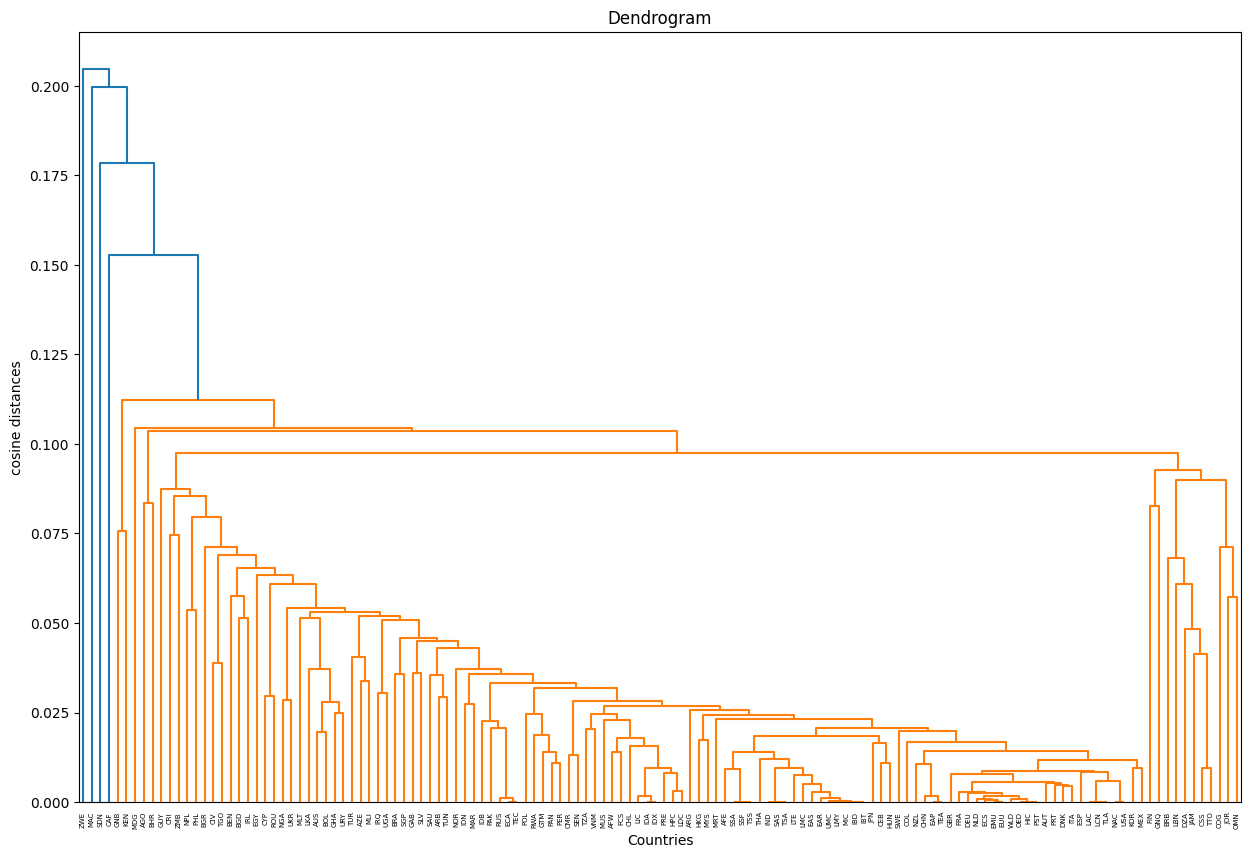

In [33]:
visualzie_dendrogram(tsne_1_dim_datasets["economic"], "cosine")

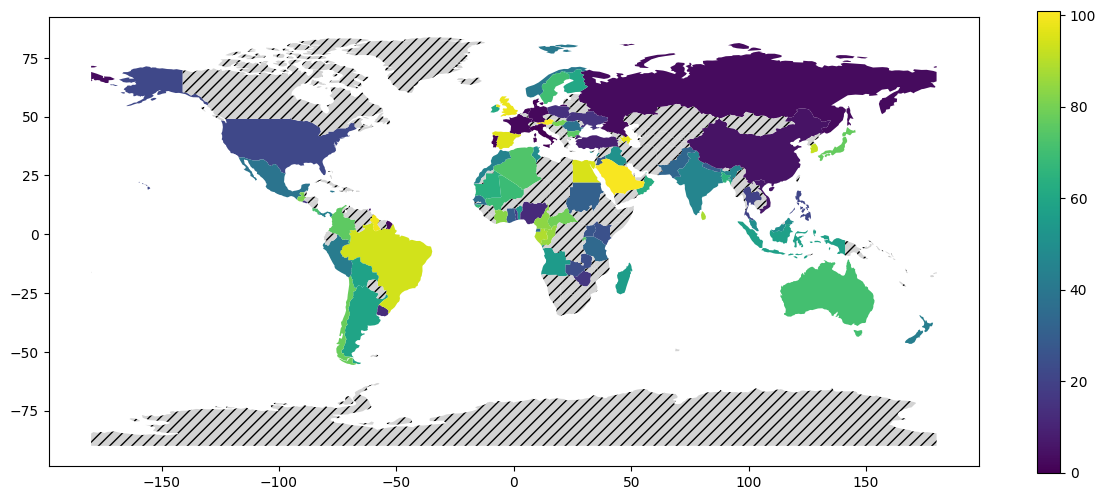

In [34]:
_countries_clustered = fit_predict_clusters(tsne_1_dim_datasets["economic"], consine_agglomerative(0.005))
visualzie_countries_clusters(_countries_clustered)

In [35]:
_most_common_economic_features = {}
_economic_clusters = group_clusters(_countries_clustered)
for label, cluster in enumerate(_economic_clusters):
    feature = most_common_features(cluster, dtw, ts_datasets["economic"])[0][0]
    _most_common_economic_features[label] = feature

['GUY']
Foreign direct investment, net inflows (% of GDP)


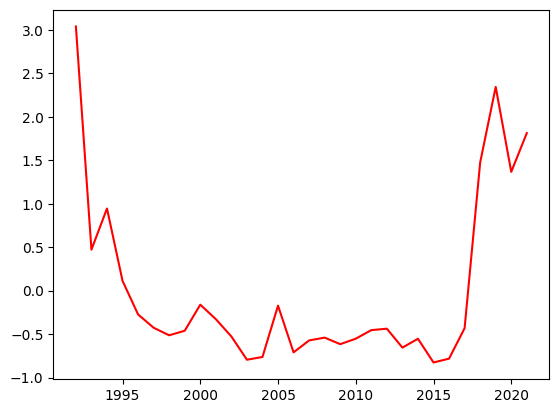

In [36]:
label = 99
cluster = _economic_clusters[label]
feature = _most_common_economic_features[label]

print(cluster)
print(feature)

plot_time_series(
    ts_datasets["economic"], 
    [(country, "red") for country in cluster],
    feature
)

### Health data

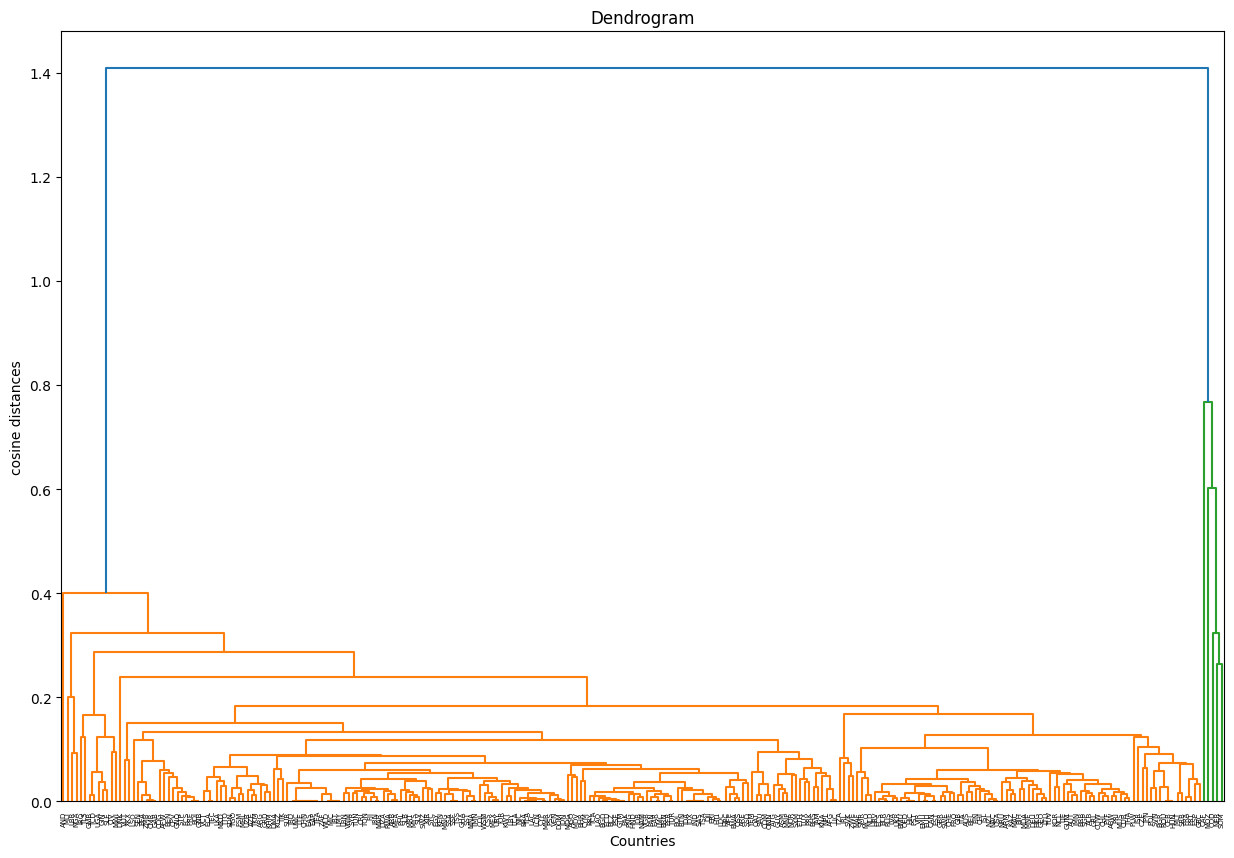

In [37]:
visualzie_dendrogram(tsne_1_dim_datasets["health"], "cosine")

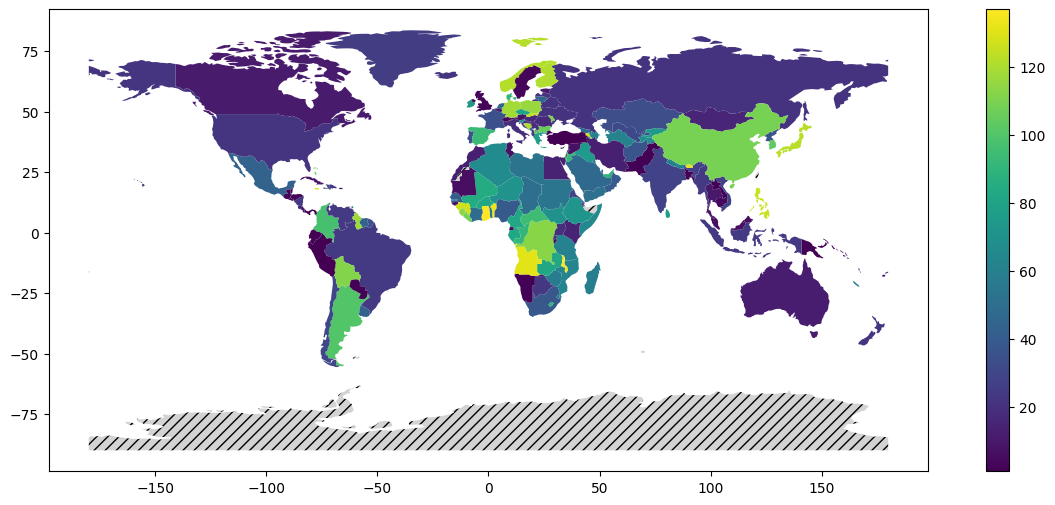

In [38]:
_countries_clustered = fit_predict_clusters(tsne_1_dim_datasets["health"], consine_agglomerative(0.02))
visualzie_countries_clusters(_countries_clustered)

In [39]:
_health_clusters = group_clusters(_countries_clustered)
_most_common_health_features = {}
for label, cluster in enumerate(_health_clusters):
    feature = most_common_features(cluster, dtw, ts_datasets["health"])[0][0]
    _most_common_health_features[label] = feature

['GRD', 'KHM']
Population ages 15-64, total


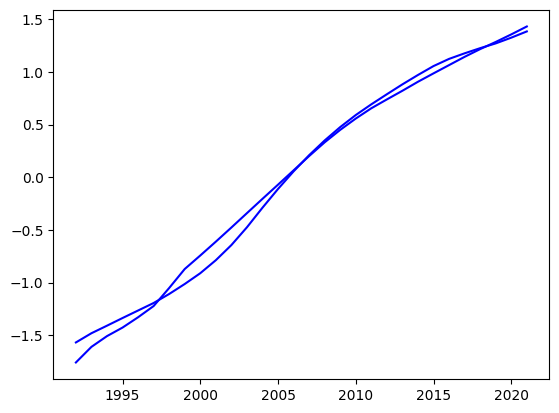

In [40]:
label = 4
cluster = _health_clusters[label]
feature = _most_common_health_features[label]

print(cluster)
print(feature)

plot_time_series(
    ts_datasets["health"], 
    [(country, "blue") for country in cluster],
    feature
)

### Social data

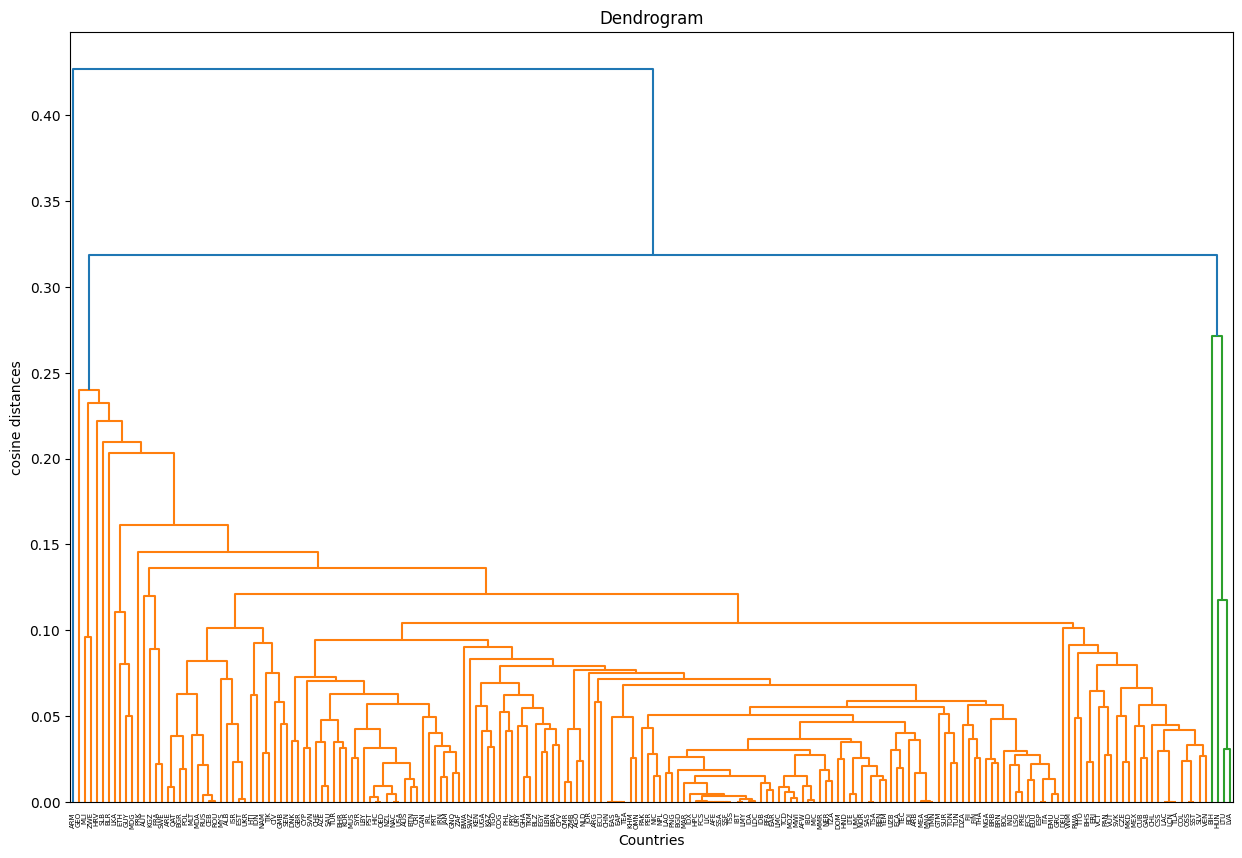

In [41]:
visualzie_dendrogram(tsne_1_dim_datasets["social"], "cosine")

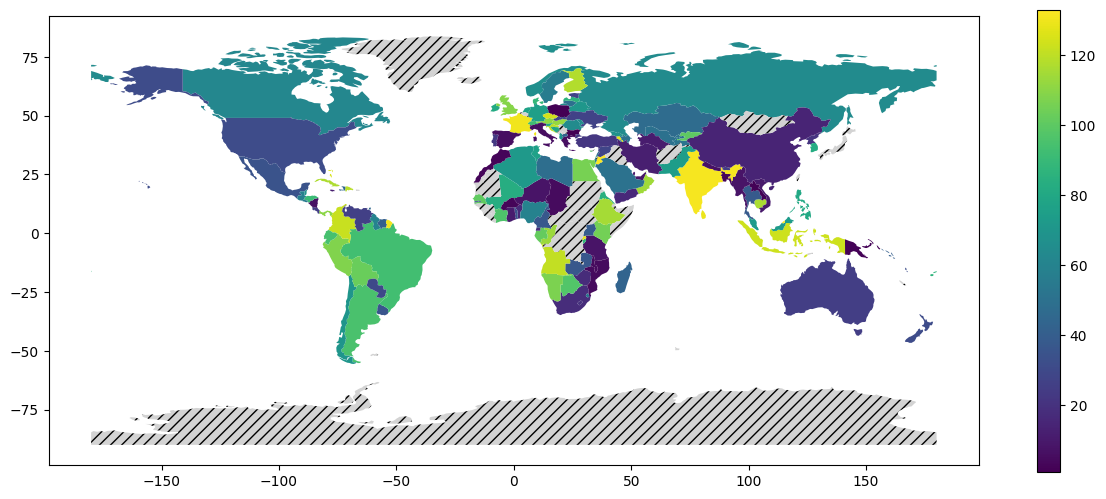

In [42]:
_countries_clustered = fit_predict_clusters(tsne_1_dim_datasets["social"], consine_agglomerative(0.02))
visualzie_countries_clusters(_countries_clustered)

In [43]:
_social_clusters = group_clusters(_countries_clustered)
_most_common_social_features = {}
for label, cluster in enumerate(_social_clusters):
    feature = most_common_features(cluster, dtw, ts_datasets["social"])[0][0]
    _most_common_social_features[label] = feature

['ZWE']
Adolescent fertility rate (births per 1,000 women ages 15-19)


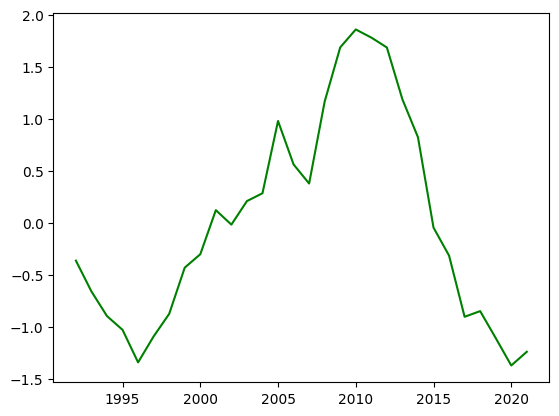

In [44]:
label = 17
cluster = _social_clusters[label]
feature = _most_common_social_features[label]

print(cluster)
print(feature)

plot_time_series(
    ts_datasets["social"], 
    [(country, "green") for country in cluster],
    feature
)

## DTW Agglomerative

In [45]:
def dtw_agglomerative(max_distance: float):
    """Returns a function which using agglomerative clustering and dynamic time wrapping finds cluster for time series (country)"""
    return AgglomerativeClustering(
        n_clusters=None, 
        distance_threshold=max_distance,
        affinity=lambda X: pairwise_distances(X, metric=dtw), 
        linkage="average"
    ).fit_predict

### Economic data

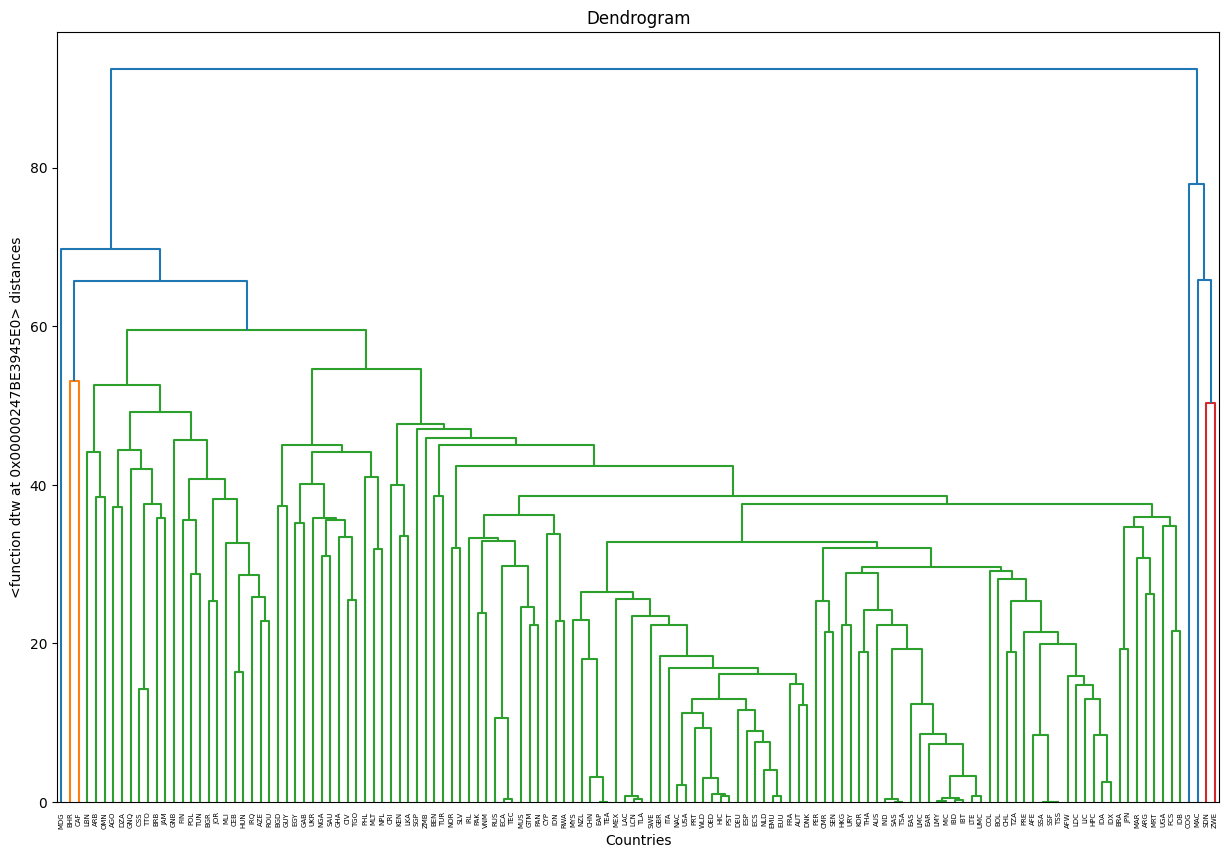

In [46]:
visualzie_dendrogram(tsne_1_dim_datasets["economic"], dtw)

c:\Dev\jupiterb\agh-data-science\venv\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


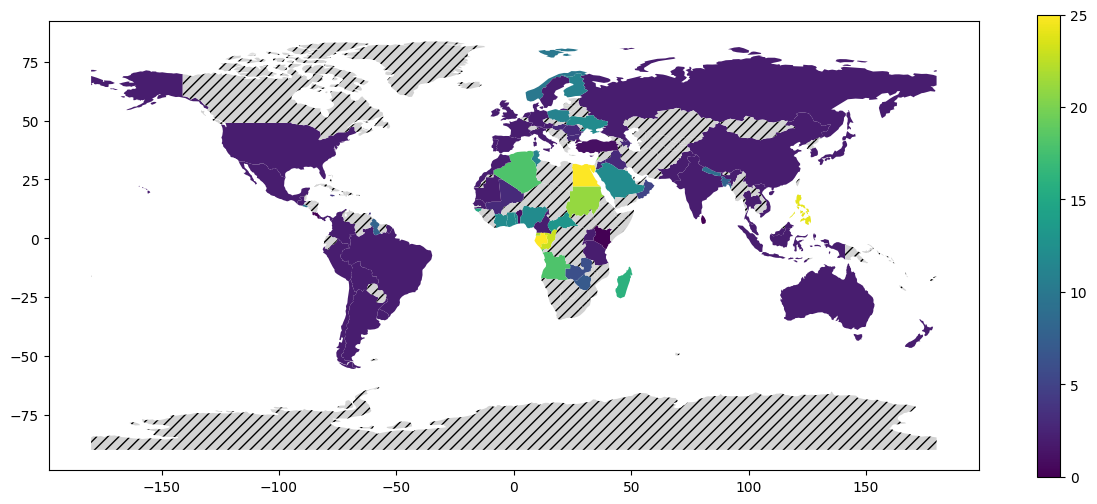

In [47]:
_countries_clustered = fit_predict_clusters(tsne_1_dim_datasets["economic"], dtw_agglomerative(40))
visualzie_countries_clusters(_countries_clustered)

In [48]:
_economic_clusters = group_clusters(_countries_clustered)
_most_common_health_clusters_features = {}
for label, cluster in enumerate(_economic_clusters):
    feature = most_common_features(cluster, dtw, ts_datasets["economic"])[0][0]
    _most_common_health_clusters_features[label] = feature

['GNB']
Foreign direct investment, net inflows (% of GDP)


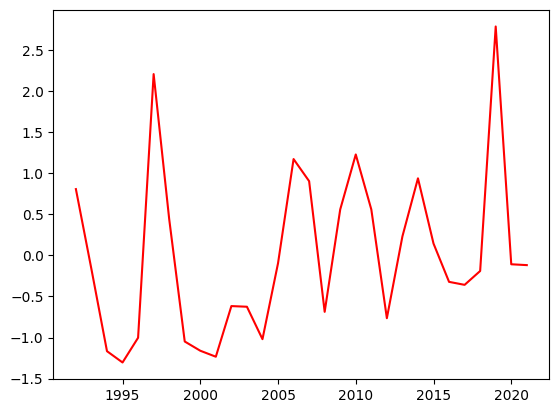

In [49]:
label = 15
cluster = _economic_clusters[label]
feature = _most_common_health_clusters_features[label]

print(cluster)
print(feature)

plot_time_series(
    ts_datasets["economic"], 
    [(country, "red") for country in cluster],
    feature
)

### Health data

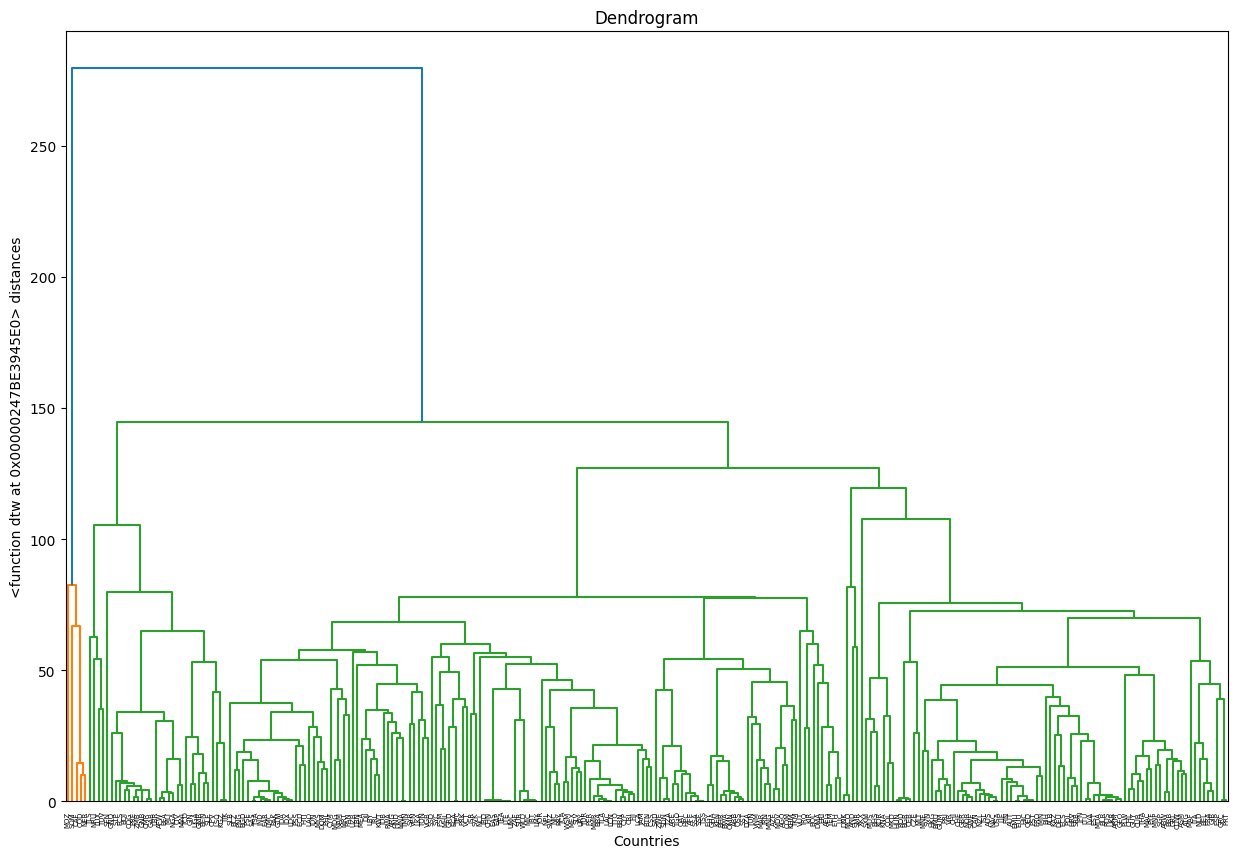

In [50]:
visualzie_dendrogram(tsne_1_dim_datasets["health"], dtw)

c:\Dev\jupiterb\agh-data-science\venv\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


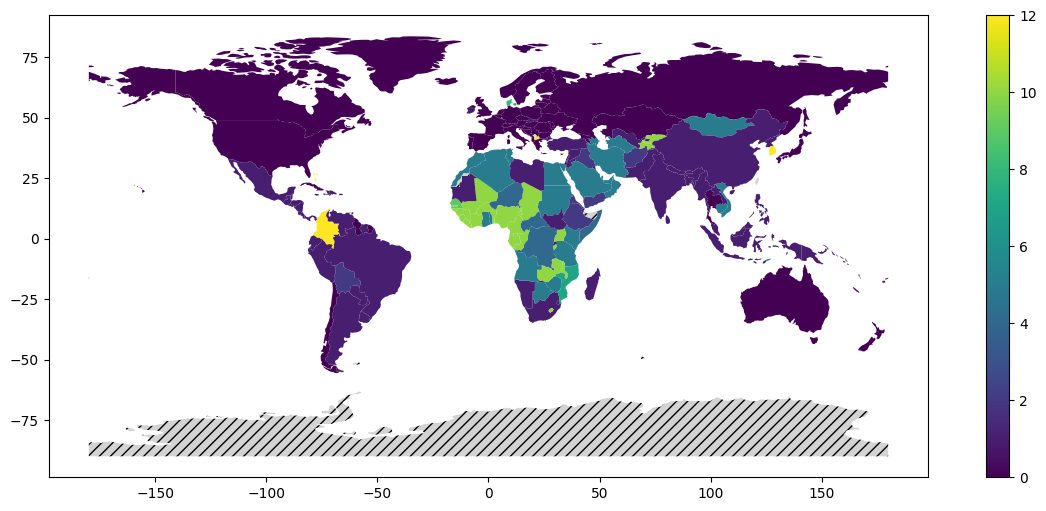

In [51]:
_countries_clustered = fit_predict_clusters(tsne_1_dim_datasets["health"], dtw_agglomerative(75))
visualzie_countries_clusters(_countries_clustered)

In [52]:
_health_clusters = group_clusters(_countries_clustered)
_most_common_health_features = {}
for label, cluster in enumerate(_health_clusters):
    feature = most_common_features(cluster, dtw, ts_datasets["health"])[0][0]
    _most_common_health_features[label] = feature

['BHS', 'COL', 'KNA', 'KOR', 'MKD', 'MUS', 'SXM']
Population ages 60-64, male (% of male population)


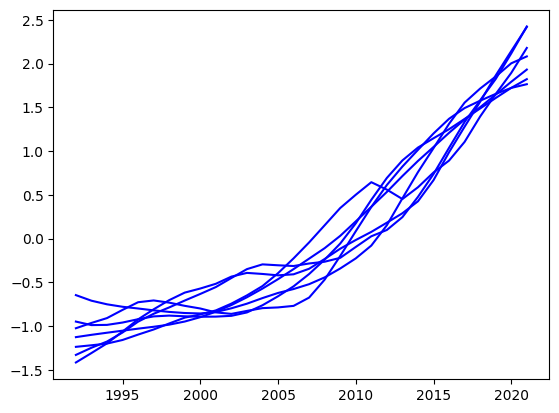

In [53]:
label = 12
cluster = _health_clusters[label]
feature = _most_common_health_features[label]

print(cluster)
print(feature)

plot_time_series(
    ts_datasets["health"], 
    [(country, "blue") for country in cluster],
    feature
)

### Social data

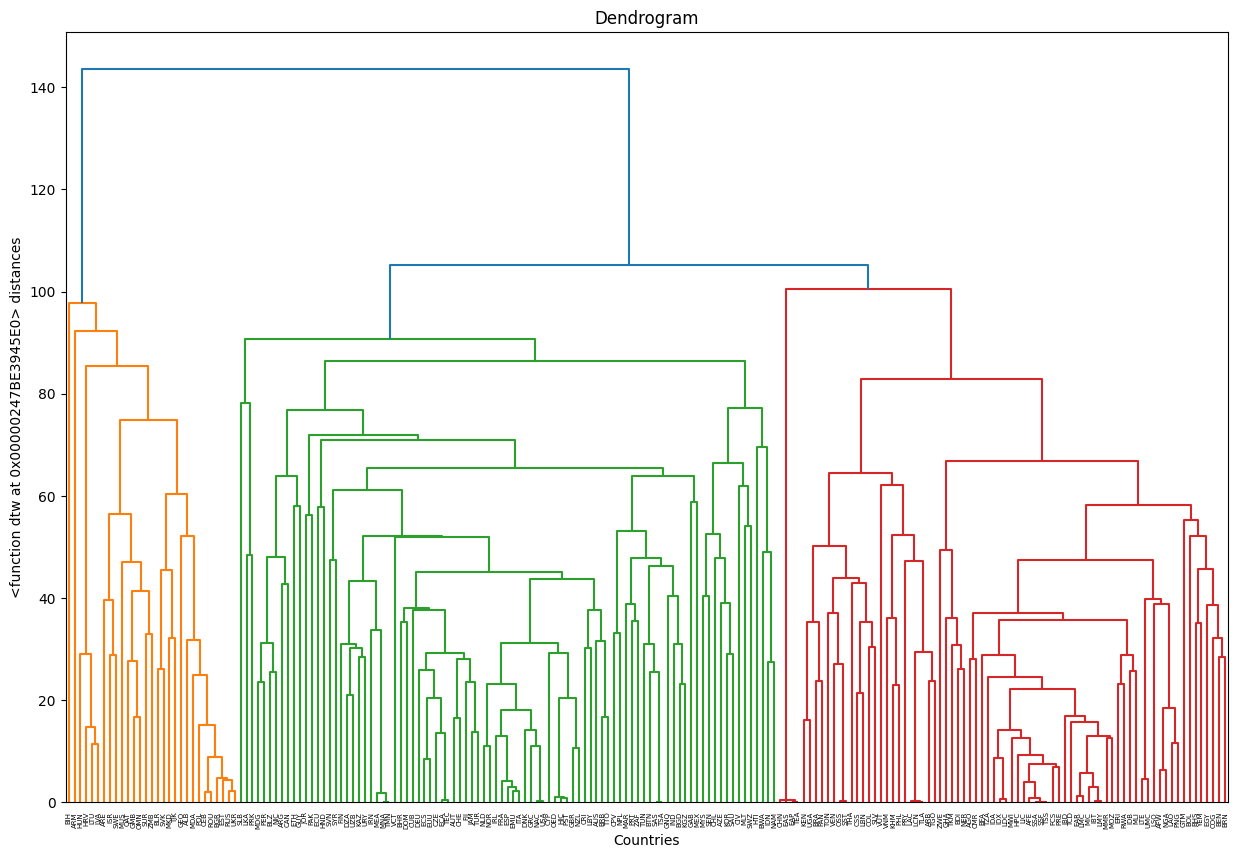

In [54]:
visualzie_dendrogram(tsne_1_dim_datasets["social"], dtw)

c:\Dev\jupiterb\agh-data-science\venv\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


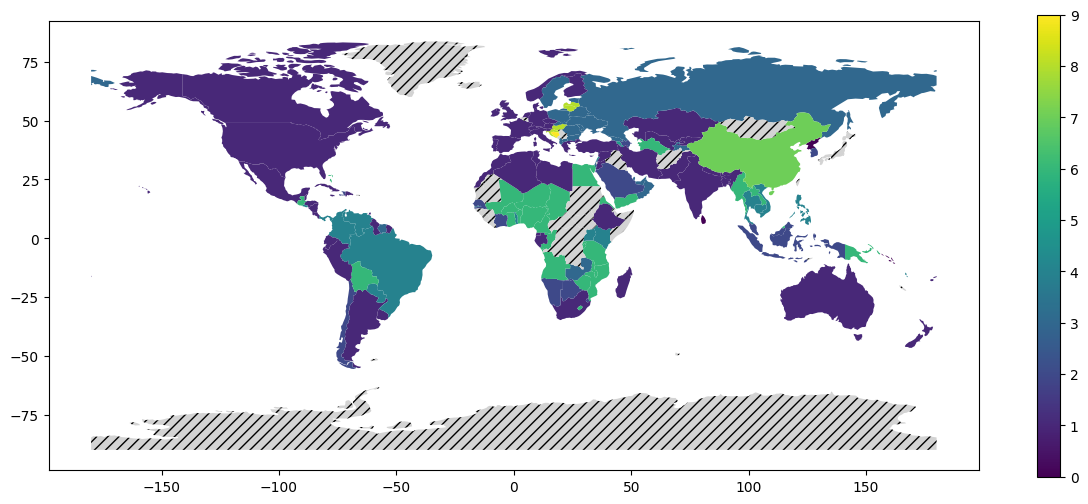

In [55]:
_countries_clustered = fit_predict_clusters(tsne_1_dim_datasets["social"], dtw_agglomerative(80))
visualzie_countries_clusters(_countries_clustered)

In [56]:
_social_clusters = group_clusters(_countries_clustered)
_most_common_social_features = {}
for label, cluster in enumerate(_social_clusters):
    feature = most_common_features(cluster, dtw, ts_datasets["social"])[0][0]
    _most_common_social_features[label] = feature

['ARG', 'AUS', 'AUT', 'BGD', 'BHR', 'BLZ', 'BRB', 'BTN', 'CAN', 'CHE', 'CPV', 'CRI', 'CUB', 'CYP', 'CZE', 'DEU', 'DNK', 'DOM', 'DZA', 'ECA', 'ECS', 'ECU', 'EMU', 'ESP', 'ETH', 'EUU', 'FIN', 'FJI', 'FRA', 'GAB', 'GBR', 'GNQ', 'GRC', 'GUY', 'HIC', 'HND', 'IND', 'IRL', 'IRN', 'ITA', 'JAM', 'JOR', 'KAZ', 'KGZ', 'LBY', 'MAR', 'MDG', 'MEA', 'MEX', 'MNA', 'NAC', 'NIC', 'NLD', 'NOR', 'NPL', 'NZL', 'OED', 'PAK', 'PER', 'PRT', 'PST', 'SAS', 'SVN', 'SYR', 'TEC', 'TMN', 'TSA', 'TTO', 'TUN', 'TUR', 'URY', 'USA', 'UZB', 'VCT', 'ZAF']
Population, total


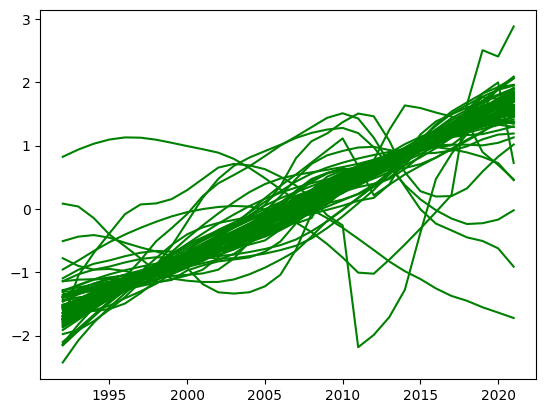

In [60]:
label = 1
cluster = _social_clusters[label]
feature = _most_common_social_features[label]

print(cluster)
print(feature)

plot_time_series(
    ts_datasets["social"], 
    [(country, "green") for country in cluster],
    feature
)

## DTW Barycenter Averaging (TSNE feature extraction)

In [58]:
dba_n_clusters = 10

countries_clustered_dba_tsne = {}
for topic, dataset in tsne_3_dim_datasets.items():
    countries = yield_countries(dataset)
    kmeans = TimeSeriesKMeans(n_clusters=dba_n_clusters, metric="dtw", max_iter=5, max_iter_barycenter=5)
    labels = kmeans.fit_predict(reshape_extract_countries_ts(dataset))
    countries_clustered = {country: label for country, label in zip(countries, labels)}
    countries_clustered_dba_tsne[topic] = countries_clustered 

### Economic data

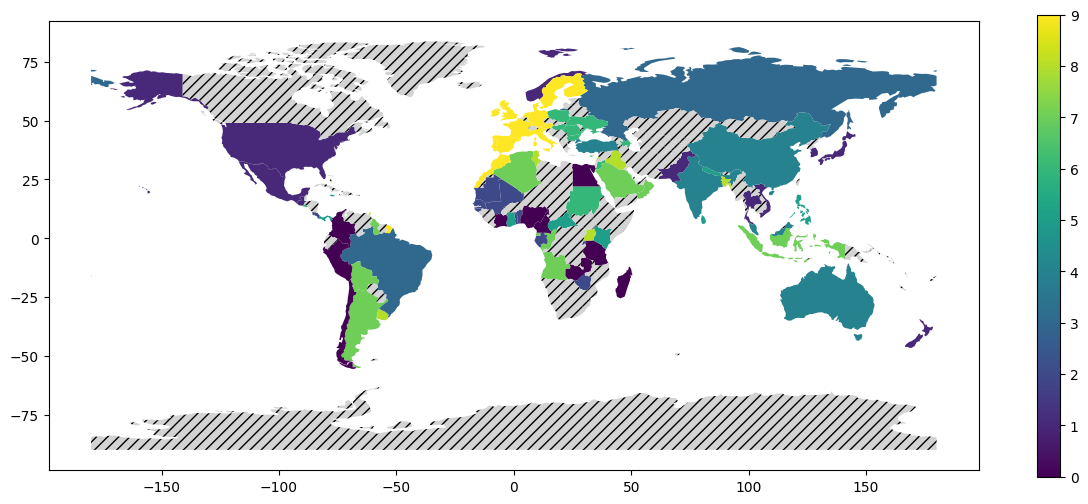

In [59]:
visualzie_countries_clusters(countries_clustered_dba_tsne["economic"])

In [61]:
_economic_clusters = group_clusters(countries_clustered_dba_tsne["economic"])
_most_common_health_clusters_features = {}
for label, cluster in enumerate(_economic_clusters):
    feature = most_common_features(cluster, dtw, ts_datasets["economic"])[0][0]
    _most_common_health_clusters_features[label] = feature

['AZE', 'BGR', 'BRB', 'CEB', 'CYP', 'HUN', 'JOR', 'MAC', 'POL', 'ROU', 'SDN', 'SLV', 'UKR']
Merchandise exports to high-income economies (% of total merchandise exports)


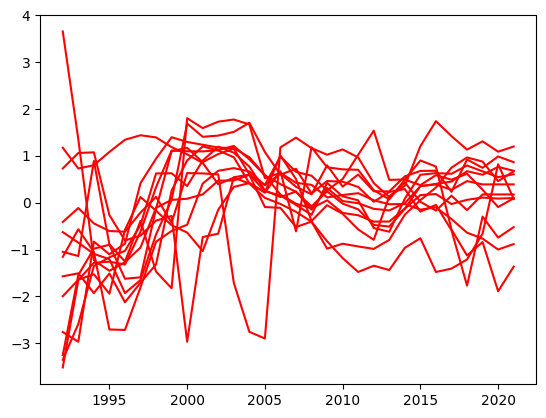

In [62]:
label = 6
cluster = _economic_clusters[label]
feature = _most_common_health_clusters_features[label]

print(cluster)
print(feature)

plot_time_series(
    ts_datasets["economic"], 
    [(country, "red") for country in cluster],
    feature
)

### Health data

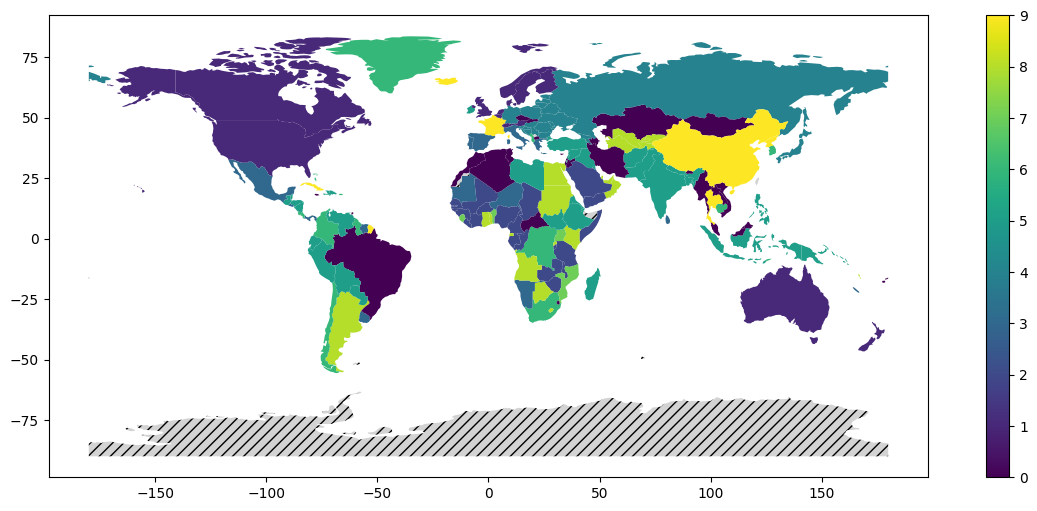

In [63]:
visualzie_countries_clusters(countries_clustered_dba_tsne["health"])

In [64]:
_health_clusters = group_clusters(countries_clustered_dba_tsne["health"])
_most_common_health_features = {}
for label, cluster in enumerate(_health_clusters):
    feature = most_common_features(cluster, dtw, ts_datasets["health"])[0][0]
    _most_common_health_features[label] = feature

['ABW', 'ATG', 'BRB', 'CHN', 'CUB', 'CUW', 'EAP', 'EAS', 'FRA', 'GIB', 'HKG', 'IBD', 'ISL', 'LTE', 'LUX', 'MAF', 'PRK', 'SGP', 'TEA', 'THA', 'UMC']
Population ages 65 and above, male (% of male population)


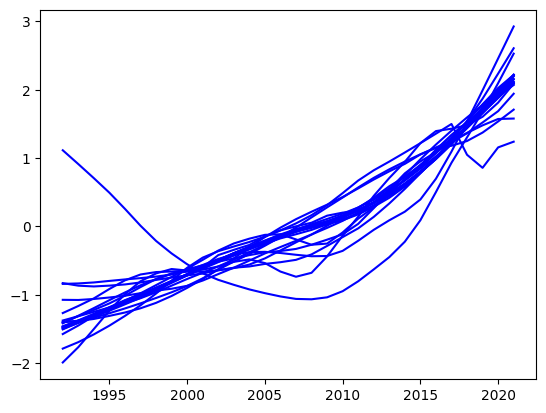

In [65]:
label = 9
cluster = _health_clusters[label]
feature = _most_common_health_features[label]

print(cluster)
print(feature)

plot_time_series(
    ts_datasets["health"], 
    [(country, "blue") for country in cluster],
    feature
)

### Social data

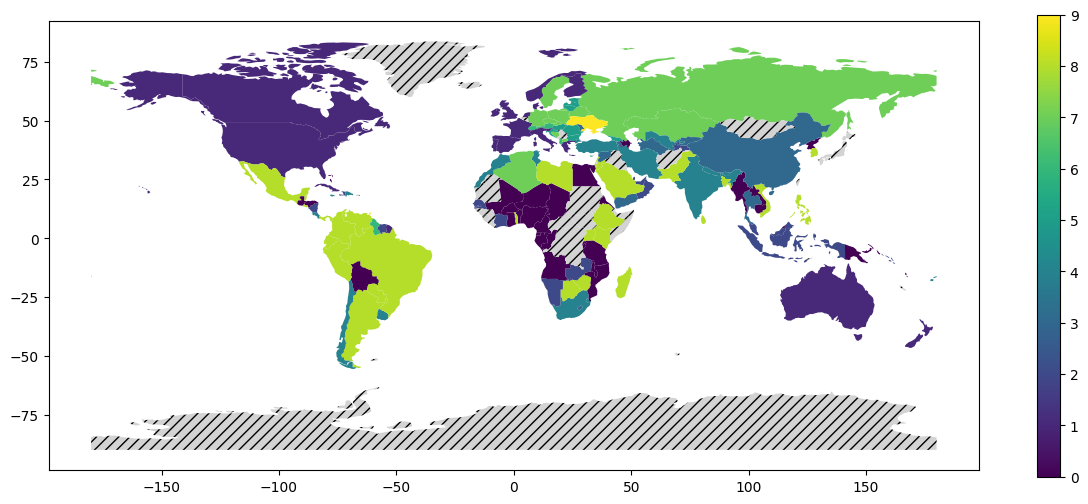

In [66]:
visualzie_countries_clusters(countries_clustered_dba_tsne["social"])

In [67]:
_social_clusters = group_clusters(countries_clustered_dba_tsne["social"])
_most_common_social_features = {}
for label, cluster in enumerate(_social_clusters):
    feature = most_common_features(cluster, dtw, ts_datasets["social"])[0][0]
    _most_common_social_features[label] = feature

['BTN', 'CHL', 'CPV', 'CRI', 'DOM', 'FJI', 'IND', 'IRN', 'JAM', 'MAR', 'MEA', 'MNA', 'NPL', 'SAS', 'SWZ', 'TMN', 'TSA', 'TUN', 'TUR', 'URY', 'UZB', 'ZAF']
Urban population


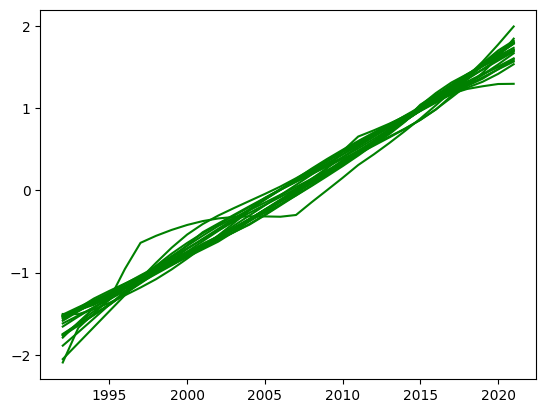

In [68]:
label = 4
cluster = _social_clusters[label]
feature = _most_common_social_features[label]

print(cluster)
print(feature)

plot_time_series(
    ts_datasets["social"], 
    [(country, "green") for country in cluster],
    feature
)

## DTW Barycenter Averaging (LSTM Autoencoder feature extraction)

In [69]:
countries_clustered_dba_lstm_ae = {}
dba_lstm_ae_centroids = {}
for topic, dataset in lstm_ae_4_dim_datasets.items():
    countries = yield_countries(dataset)
    kmeans = TimeSeriesKMeans(n_clusters=dba_n_clusters, metric="dtw", max_iter=5, max_iter_barycenter=5)
    labels = kmeans.fit_predict(reshape_extract_countries_ts(dataset))
    countries_clustered = {country: label for country, label in zip(countries, labels)}
    countries_clustered_dba_lstm_ae[topic] = countries_clustered 
    dba_lstm_ae_centroids[topic] = lstm_ae_4_dim[topic].decode(kmeans.cluster_centers_)

### Economic data

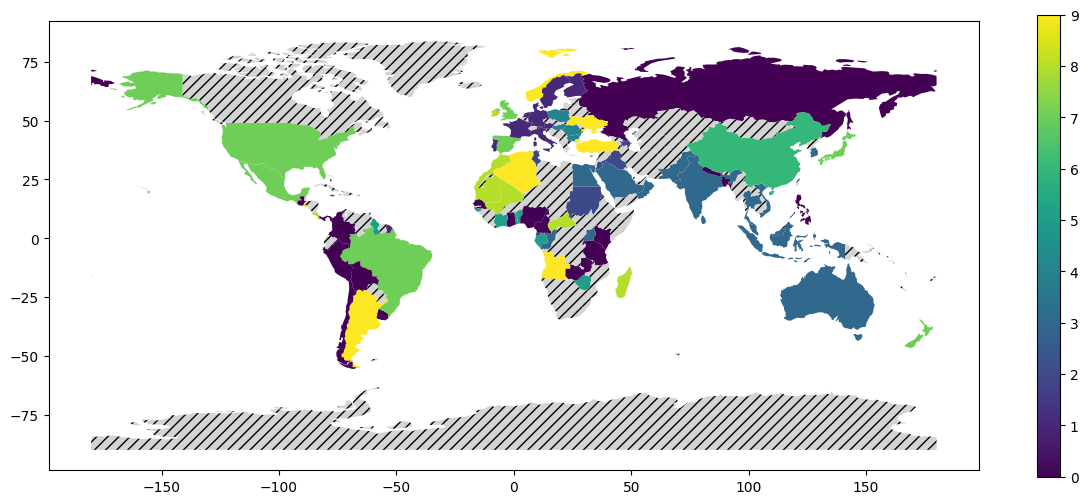

In [70]:
visualzie_countries_clusters(countries_clustered_dba_lstm_ae["economic"])

In [71]:
_economic_clusters = group_clusters(countries_clustered_dba_lstm_ae["economic"])
_most_common_health_clusters_features = {}
for label, cluster in enumerate(_economic_clusters):
    feature = most_common_features(cluster, dtw, ts_datasets["economic"])[0][0]
    _most_common_health_clusters_features[label] = feature

['AGO', 'ARG', 'CSS', 'DZA', 'ECA', 'MLT', 'NOR', 'SLV', 'TEC', 'TUR', 'UKR']
Merchandise imports from low- and middle-income economies outside region (% of total merchandise imports)


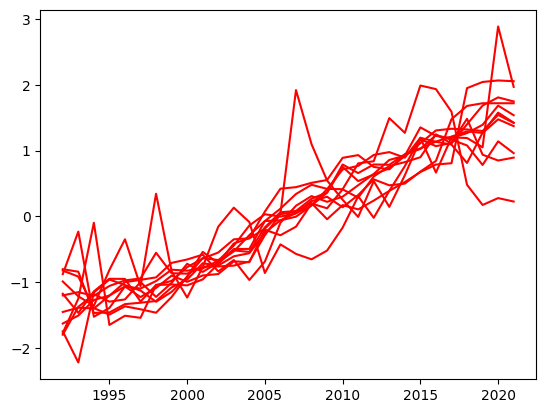

In [72]:
label = 9
cluster = _economic_clusters[label]
feature = _most_common_health_clusters_features[label]

print(cluster)
print(feature)

plot_time_series(
    ts_datasets["economic"], 
    [(country, "red") for country in cluster],
    feature
)

### Health data

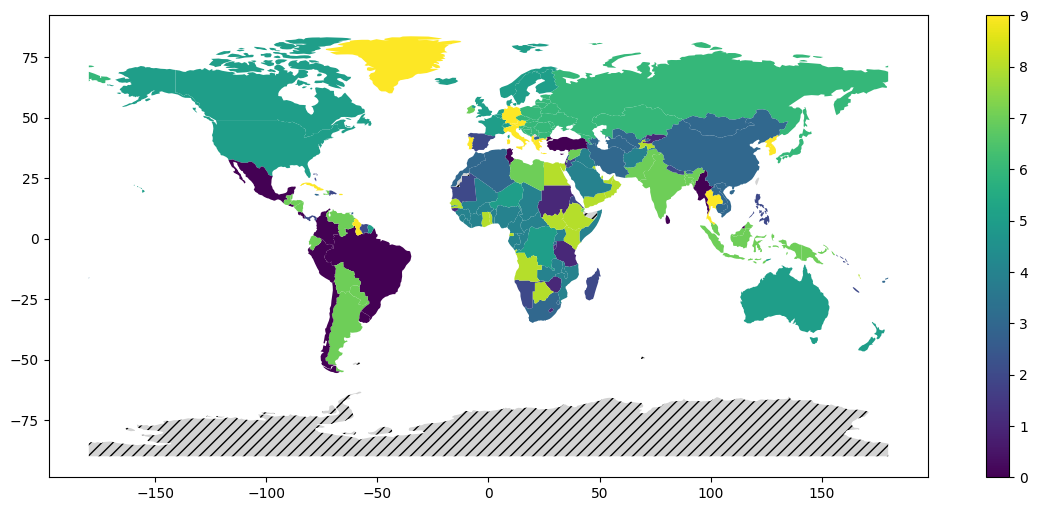

In [73]:
visualzie_countries_clusters(countries_clustered_dba_lstm_ae["health"])

In [74]:
_health_clusters = group_clusters(countries_clustered_dba_lstm_ae["health"])
_most_common_health_features = {}
for label, cluster in enumerate(_health_clusters):
    feature = most_common_features(cluster, dtw, ts_datasets["health"])[0][0]
    _most_common_health_features[label] = feature

['ABW', 'ALB', 'ASM', 'AUT', 'BMU', 'BRB', 'CUB', 'CUW', 'DEU', 'EMU', 'EUU', 'GRC', 'GRL', 'GUM', 'GUY', 'HIC', 'HKG', 'ITA', 'KOR', 'MAF', 'MNP', 'OED', 'PLW', 'PRI', 'PRK', 'PRT', 'PST', 'SGP', 'THA', 'VIR']
Age dependency ratio, old (% of working-age population)


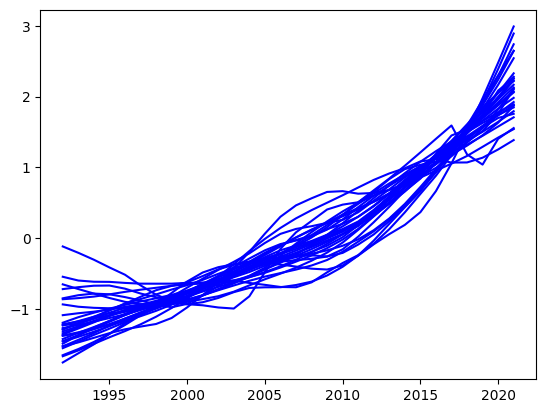

In [75]:
label = 9
cluster = _health_clusters[label]
feature = _most_common_health_features[label]

print(cluster)
print(feature)

plot_time_series(
    ts_datasets["health"], 
    [(country, "blue") for country in cluster],
    feature
)

### Social data

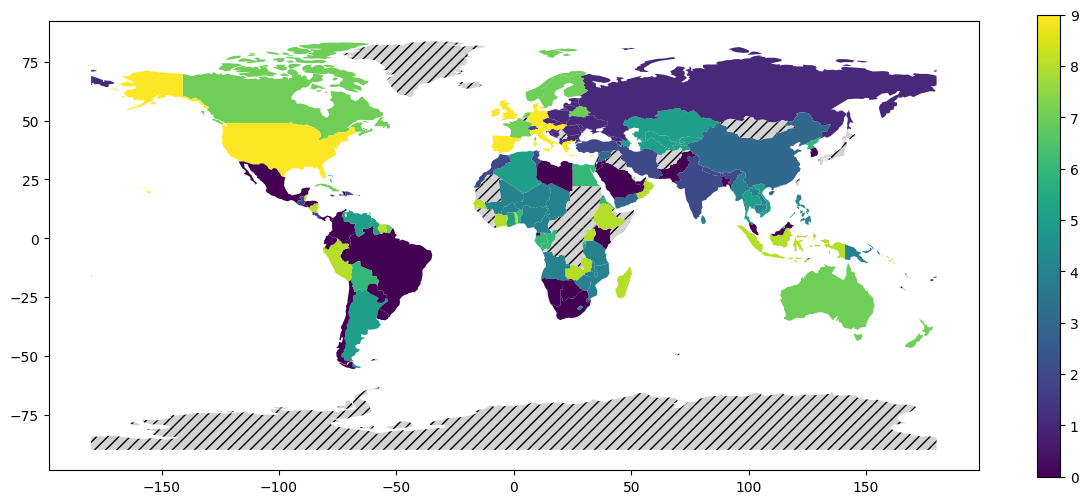

In [76]:
visualzie_countries_clusters(countries_clustered_dba_lstm_ae["social"])

In [77]:
_social_clusters = group_clusters(countries_clustered_dba_lstm_ae["social"])
_most_common_social_features = {}
for label, cluster in enumerate(_social_clusters):
    feature = most_common_features(cluster, dtw, ts_datasets["social"])[0][0]
    _most_common_social_features[label] = feature

['AUT', 'BRB', 'CYP', 'DEU', 'DNK', 'ECS', 'EMU', 'ESP', 'EUU', 'GBR', 'GRC', 'HIC', 'HUN', 'IRL', 'ITA', 'NAC', 'OED', 'PRT', 'PST', 'SVN', 'USA', 'VCT']
Forest area (sq. km)


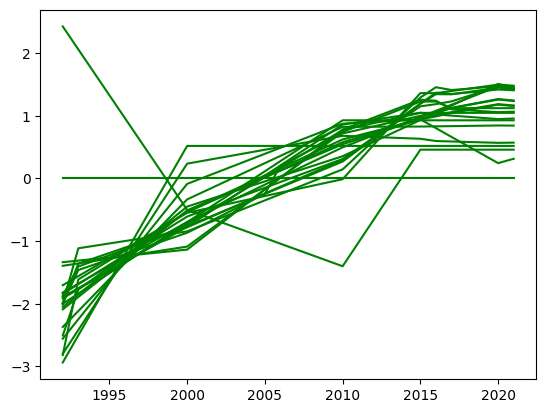

In [78]:
label = 9
cluster = _social_clusters[label]
feature = _most_common_social_features[label]

print(cluster)
print(feature)

plot_time_series(
    ts_datasets["social"], 
    [(country, "green") for country in cluster],
    feature
)